In [1]:
# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd

# ------------------- Plotting ------------------- #
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ------------------- Python libs ---------------- #
import os, sys, re
from pathlib import Path
ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH)) # Add folder root path
METADATA_PATH = Path('../data/CORD-19/CORD-19/metadata.csv')

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')

## I. Load data

In [2]:
!head -n 1 ../data/CORD-19/CORD-19/metadata.csv

cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id


Out all the columns we only want - `cord_uid`, `title`, & `abstract` to build index on and `source_x`, `publish_time` and `journal` to understand how data is distributed. 

In [3]:
def read_csv_strip(fpath, columns_to_keep=[], date_columns=[], index_col=None):
    
    df = pd.read_csv(fpath, quotechar='"', parse_dates=date_columns, index_col=index_col, low_memory=False)
    # keep needed columns
    df = df[columns_to_keep]
    # for each column
    for col in df.columns:
        # check if the columns contains string data
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].str.strip() # removes front and end white spaces
            df[col] = df[col].str.replace('\s{2,}', ' ') # remove double or more white spaces
    df = df.replace({"":np.nan}) # if there remained only empty string "", change to Nan
    return df


columns_to_keep = ['cord_uid', 'title', 'abstract', 'source_x', 'publish_time', 'journal']
date_columns = ['publish_time']

metadata = read_csv_strip(METADATA_PATH, columns_to_keep=columns_to_keep, date_columns=date_columns)
metadata.head()

,cord_uid,title,abstract,source_x,publish_time,journal
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,PMC,2001-07-04,BMC Infect Dis
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,PMC,2000-08-15,Respir Res
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,PMC,2000-08-25,Respir Res
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,PMC,2001-02-22,Respir Res
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,PMC,2001-05-11,Respir Res


## II. Pre-process

### a. Verify data type


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128492 entries, 0 to 128491
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   cord_uid      128492 non-null  object        
 1   title         128464 non-null  object        
 2   abstract      101611 non-null  object        
 3   source_x      128492 non-null  object        
 4   publish_time  128477 non-null  datetime64[ns]
 5   journal       122195 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 5.9+ MB


In total dataset is ~ 6 MB in size which is much easier to process compared to incorporating full-text data and total of 128,000 documents in the dataset.

### b. Check missing values

In [5]:
(metadata.isnull().sum() / metadata.shape[0]) * 100

cord_uid         0.000000
title            0.021791
abstract        20.920369
source_x         0.000000
publish_time     0.011674
journal          4.900694
dtype: float64

`abstract` is missing in most documents along with `title`, so it's better to create another column with `title+abstract` and drop those documents that are missing both of them. But let's first fill missing values with empty string in `title` and `abstract` and drop rows that have length min. length of title.

In [6]:
metadata = metadata.fillna({'title': '', 'abstract': ''})
(metadata.isnull().sum() / metadata.shape[0]) * 100

cord_uid        0.000000
title           0.000000
abstract        0.000000
source_x        0.000000
publish_time    0.011674
journal         4.900694
dtype: float64

In [7]:
metadata['title+abstract'] = metadata['title'] + ' ' + metadata['abstract']
metadata.head()

,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,PMC,2001-07-04,BMC Infect Dis,Clinical features of culture-proven Mycoplasma...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,PMC,2000-08-15,Respir Res,Nitric oxide: a pro-inflammatory mediator in l...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,PMC,2000-08-25,Respir Res,Surfactant protein-D and pulmonary host defens...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,PMC,2001-02-22,Respir Res,Role of endothelin-1 in lung disease Endotheli...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,PMC,2001-05-11,Respir Res,Gene expression in epithelial cells in respons...


In [8]:
metadata['title+abstract'].str.len().describe()

count    128492.000000
mean       1170.048369
std         953.268327
min           1.000000
25%         514.000000
50%        1238.000000
75%        1737.000000
max      122459.000000
Name: title+abstract, dtype: float64

We can see min. length for both `title+abstract` column is 1 which are missing values for both columns, thus it is safe to drop those, while median length is ~ 1k and max. length is ~ 12k words.

In [9]:
metadata['title'].str.len().describe()

count    128492.000000
mean         93.554898
std          42.033980
min           0.000000
25%          64.000000
50%          90.000000
75%         119.000000
max         469.000000
Name: title, dtype: float64

In [10]:
metadata['abstract'].str.len().describe()

count    128492.000000
mean       1075.493470
std         939.997251
min           0.000000
25%         434.000000
50%        1142.000000
75%        1628.000000
max      122392.000000
Name: abstract, dtype: float64

Comparing `title` and `abstract`, most Title are about 90 words in length and Abstract's are ~ 1k in length. So combinging both of them should provide better coverage for retrieval system.

Let's now drop the rows that are missing both `title` and `abstract`.

In [11]:
metadata[metadata['title+abstract'].str.len() < 2].sample(10, random_state=0)

,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract
44953,jlucw365,,,Medline,2018-01-01,Der Chirurg; Zeitschrift fur alle Gebiete der ...,
44337,jui6jw60,,,Medline,2020-05-05,Tidsskrift for den Norske laegeforening : tids...,
55251,89gdvp9b,,,Medline,2016-01-01,Jornal vascular brasileiro,
45984,qsflkeku,,,Medline,2020-04-09,Laryngo- rhino- otologie,
55042,ho8y52ml,,,Medline,2020-03-31,Laryngo- rhino- otologie,
26599,d8um2u8n,,,Medline,2020-05-05,Tidsskrift for den Norske laegeforening : tids...,
45861,xae7fzph,,,Medline,2018-01-01,Der Chirurg; Zeitschrift fur alle Gebiete der ...,
56337,fey0ejcq,,,Medline,2020-05-05,Tidsskrift for den Norske laegeforening : tids...,
51296,q9z4grhy,,,Medline,2020-05-05,Tidsskrift for den Norske laegeforening : tids...,
40155,4x5dsxas,,,Medline,2020-05-05,Tidsskrift for den Norske laegeforening : tids...,


Looks like above missing rows come from european journals that publish in their native language. Since the goal is not to do Cross-Language IR we can safely drop them now.

In [12]:
metadata = metadata[~(metadata['title+abstract'].str.len() < 2)]
metadata.reset_index(drop=True, inplace=True)
metadata['title+abstract'].str.len().describe()

count    128469.000000
mean       1170.257665
std         953.225299
min           4.000000
25%         514.000000
50%        1239.000000
75%        1737.000000
max      122459.000000
Name: title+abstract, dtype: float64

### c) Filter `title+abstract` rows with duplicated and text length < 15 words

Let's now count the total number of words per `title+abstract` document as it will help us further filter down unnecessary documents that don't contain any necessary information. 

In [13]:
metadata['title+abstract_wc'] = metadata['title+abstract'].progress_apply(lambda x: len(x.split()))
metadata.head()

100%|██████████| 128469/128469 [00:01<00:00, 78220.07it/s]


,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract,title+abstract_wc
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,PMC,2001-07-04,BMC Infect Dis,Clinical features of culture-proven Mycoplasma...,277
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,PMC,2000-08-15,Respir Res,Nitric oxide: a pro-inflammatory mediator in l...,150
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,PMC,2000-08-25,Respir Res,Surfactant protein-D and pulmonary host defens...,225
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,PMC,2001-02-22,Respir Res,Role of endothelin-1 in lung disease Endotheli...,74
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,PMC,2001-05-11,Respir Res,Gene expression in epithelial cells in respons...,120


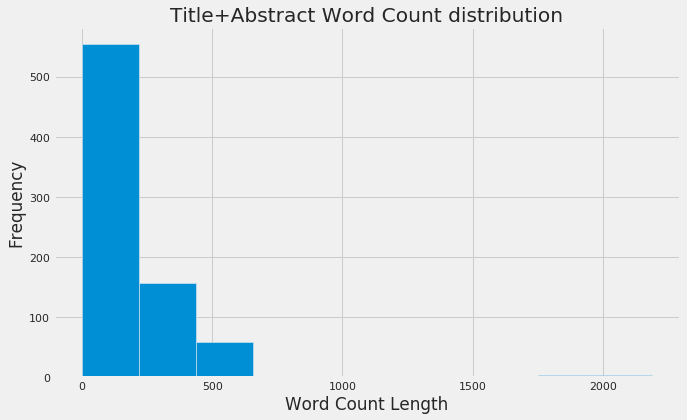

In [14]:
plt.figure(figsize=(10, 6))
ax = metadata['title+abstract_wc'].value_counts().plot.hist()
ax.set_title('Title+Abstract Word Count distribution')
ax.set_xlabel('Word Count Length');

In [15]:
metadata['title+abstract_wc'].describe()

count    128469.000000
mean        169.000529
std         137.788438
min           1.000000
25%          73.000000
50%         177.000000
75%         253.000000
max       18010.000000
Name: title+abstract_wc, dtype: float64

#### WC == 1

Let's look at those documents that have word count of length 1. 

In [16]:
metadata[(metadata['title+abstract_wc'] == 1)][['title+abstract', 'title+abstract_wc']].sample(15, random_state=0)

,title+abstract,title+abstract_wc
114760,Verrast,1
8102,Autopsy,1
57466,Correction,1
17061,Anhang,1
23653,Bronchiolitis,1
21997,Enteritis,1
15780,Myokarditis,1
22910,Proteases,1
23748,Omslagpunt,1
18222,Viszeralchirurgie,1


Given that there is not much information that can match to a query to be able to be retrieved from this documents it's better to drop them. 

In [17]:
metadata = metadata[~(metadata['title+abstract_wc'] < 2)]
metadata.reset_index(drop=True, inplace=True)
metadata['title+abstract_wc'].describe()

count    127945.000000
mean        169.688577
std         137.649349
min           2.000000
25%          76.000000
50%         178.000000
75%         253.000000
max       18010.000000
Name: title+abstract_wc, dtype: float64

In [18]:
metadata[(metadata['title+abstract_wc'] > 2) & (metadata['title+abstract_wc'] < 5)].sample(15, random_state=0)

,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract,title+abstract_wc
8197,623yva2l,ICAR 2011: Abstracts,,PMC,2011-03-13,Infection,ICAR 2011: Abstracts,3
43685,bcuivyku,Covid-19 and Namaste.,,Medline,2020-04-21,Influenza and other respiratory viruses,Covid-19 and Namaste.,3
23109,lhpy3d3p,Contents to volume 14,,PMC,2002-11-12,J Virol Methods,Contents to volume 14,4
68611,1blpr5ay,Health and social justice.,,Medline,2004-01-01,Lancet,Health and social justice.,4
85559,99fgkc3g,Editorial - COVID-19,,WHO,2020-01-01,Br J Haematol,Editorial - COVID-19,3
93788,hs9e4tz2,Mechanisms of Demyelination,,Elsevier; PMC,1985-03-02,The Lancet,Mechanisms of Demyelination,3
78105,ybpp5xv2,Dialysis and transplantation.,,Medline,1968-01-01,The New England journal of medicine,Dialysis and transplantation.,3
121406,70vneh6r,COVID-19 Disaster Response Assessment,,Medline; WHO,2020-01-01,J Burn Care Res,COVID-19 Disaster Response Assessment,4
123477,75oun377,Science news top 25,,Medline; PMC,2013-12-18,Sci News,Science news top 25,4
101798,3r7yzukp,Reply to Lipsitch,,Medline; PMC,2016-10-15,J Infect Dis,Reply to Lipsitch,3


Again we don't see that much information in the combined column, some of them tend to be news or articles which have much less information to tell us if they are relevant to a given query without reading the full text.

Now let's investigate duplicated cord_uid's

In [19]:
duplicated_metadata = metadata[metadata.duplicated(["cord_uid"])]
duplicated_metadata.head()

,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract,title+abstract_wc
13805,uae2ek12,Protect Healthcare Workers and Patients from C...,,PMC,2020-04-24,Ophthalmol Ther,Protect Healthcare Workers and Patients from C...,18
22438,jsk1oztb,"‘Promoted by Hong Tao, the Chlamydia Hypothesi...",Purpose – The aims of this chapter are twofold...,PMC,2010-04-21,NaN,"‘Promoted by Hong Tao, the Chlamydia Hypothesi...",280
22458,jsk1oztb,"‘Promoted by Hong Tao, the Chlamydia Hypothesi...",Purpose – The aims of this chapter are twofold...,PMC,2010-04-21,NaN,"‘Promoted by Hong Tao, the Chlamydia Hypothesi...",280
29246,nmchd4ib,Surveillance of vector-borne diseases in Germa...,The changing epidemiology of vector-borne dise...,Medline,2008-01-01,Parasitology research,Surveillance of vector-borne diseases in Germa...,303
30097,u9jdb2nw,Exportations of Symptomatic Cases of MERS-CoV ...,"In 2012, an outbreak of infection with Middle ...",Medline,2016-01-01,Emerging infectious diseases,Exportations of Symptomatic Cases of MERS-CoV ...,65


In [20]:
duplicated_metadata.shape

(328, 8)

Looks like there are ~300 duplicated `corduids` so we can drop them and keep the first ones only.

In [21]:
metadata.drop_duplicates(subset=['cord_uid'], keep='first', inplace=True)
metadata.reset_index(drop=True, inplace=True)
metadata[metadata.duplicated(["cord_uid"])]

,cord_uid,title,abstract,source_x,publish_time,journal,title+abstract,title+abstract_wc


In [22]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127617 entries, 0 to 127616
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   cord_uid           127617 non-null  object        
 1   title              127617 non-null  object        
 2   abstract           127617 non-null  object        
 3   source_x           127617 non-null  object        
 4   publish_time       127602 non-null  datetime64[ns]
 5   journal            121369 non-null  object        
 6   title+abstract     127617 non-null  object        
 7   title+abstract_wc  127617 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 7.8+ MB


## III. Save Cleaned Data set

In [23]:
processed_metadata = metadata[['cord_uid', 'title', 'abstract', 'title+abstract']]
processed_metadata.head()

,cord_uid,title,abstract,title+abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,Clinical features of culture-proven Mycoplasma...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,Nitric oxide: a pro-inflammatory mediator in l...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,Surfactant protein-D and pulmonary host defens...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Role of endothelin-1 in lung disease Endotheli...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,Gene expression in epithelial cells in respons...


In [24]:
PROCESSED_FPATH = Path('../data') / 'trec_cord19_v0.csv'
processed_metadata.to_csv(PROCESSED_FPATH, index=False)